In [1]:
import matplotlib
#matplotlib.use('Agg')
from path_data_variable import *
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

In [2]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [3]:
wine = Table.read_table(path_data + 'wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))

In [4]:
shuffled_wine = wine.sample(with_replacement=False) 
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

In [5]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    return count_equal(c, test.column('Class')) / test.num_rows

In [6]:
evaluate_accuracy(training_set, test_set, 5)

0.898876404494382

In [7]:
patients = Table.read_table(path_data + 'breast-cancer.csv').drop('ID')
patients

Clump Thickness | Uniformity of Cell Size | Uniformity of Cell Shape | Marginal Adhesion | Single Epithelial Cell Size | Bare Nuclei | Bland Chromatin | Normal Nucleoli | Mitoses | Class
5               | 1                       | 1                        | 1                 | 2                           | 1           | 3               | 1               | 1       | 0
5               | 4                       | 4                        | 5                 | 7                           | 10          | 3               | 2               | 1       | 0
3               | 1                       | 1                        | 1                 | 2                           | 2           | 3               | 1               | 1       | 0
6               | 8                       | 8                        | 1                 | 3                           | 4           | 3               | 7               | 1       | 0
4               | 1                       | 1                        | 3                 | 2                           | 1           | 3               | 1               | 1       | 0
8               | 10                      | 10                       | 8                 | 7                           | 10          | 9               | 7               | 1       | 1
1               | 1                       | 1                        | 1                 | 2                           | 10          | 3               | 1               | 1       | 0
2               | 1                       | 2                        | 1                 | 2                           | 1           | 3               | 1               | 1       | 0
2               | 1                       | 1                        | 1                 | 2                           | 1           | 1               | 1               | 5       | 0
4               | 2                       | 1                        | 1                 | 2                           | 1           | 2               | 1               | 1       | 0
... (673 rows omitted)

In [8]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
patients_with_colors = patients.join('Class', color_table)

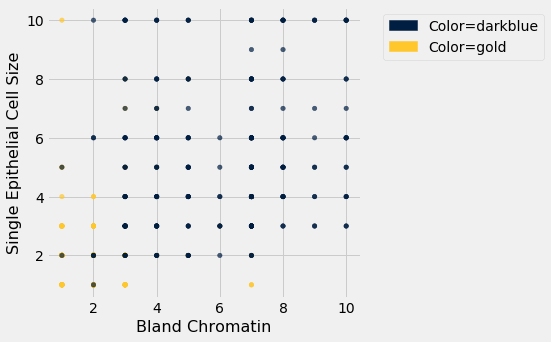

In [9]:
patients_with_colors.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Color')

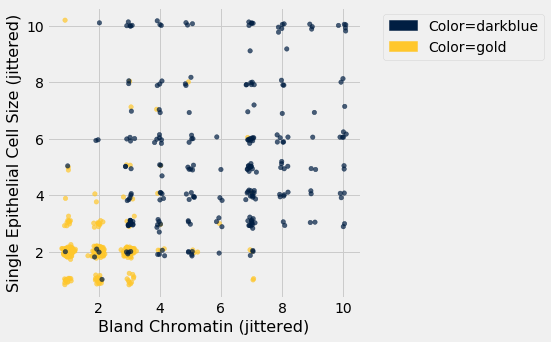

In [10]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))
Table().with_columns(
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class', patients.column('Class')
    ).join('Class', color_table).scatter(1, 2, group='Color')

In [11]:
shuffled_patients = patients.sample(683, with_replacement=False) 
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

In [12]:
evaluate_accuracy(training_set, test_set, 5)

0.967741935483871